# Imports

In [111]:
import os
import sys
import h5py
import time
import youtube_dl

import numpy as np
import pandas as pd

import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
from ipywidgets import interact
from IPython.display import YouTubeVideo, Markdown, display, Video, Image

from tqdm.notebook import tqdm
tqdm.pandas()

In [112]:
from src.common.path_resolvers import resolve_interval_raw_text_path
from src.common.display_utils import display_value_counts, printmd
from src.common.constants import FRAME_RATE

In [35]:
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken/src')
sys.path.append('/Users/staveshemesh/Projects/shstav2/token_voken')
sys.path.append('/home/stav/Projects/token_voken')

In [36]:
pd.set_option('display.max_colwidth', 200)
pd.options.display.float_format = '{:,.2f}'.format

# Constants

In [115]:
SPEAKER_NAME = 'noah'
INTERVALS_PATH = '/home/stav/Data/PATS_DATA/df_intervals_all.csv'
VIDEOS_PATH = '/home/stav/Data/PATS_DATA/df_videos_all.csv'

In [191]:
df_intervals_all = pd.read_csv(INTERVALS_PATH)
MASK_SPEAKER = df_intervals_all['speaker'] == SPEAKER_NAME
df_intervals = df_intervals_all[MASK_SPEAKER].copy()
df_intervals.rename(columns={'delta_time': 'duration'}, inplace=True)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [195]:
LIST_BULLET = '  ◘ '
TAB = '&nbsp;&nbsp;&nbsp;&nbsp;'
VIDEO_ID_LEN = 11

In [196]:
! echo {PATS_SPEAKER_PATS_INTERVAL_DIR}
print('   Total Intervals:', end=' ')
! ls -al {PATS_SPEAKER_PATS_INTERVAL_DIR} | wc -l

{PATS_SPEAKER_PATS_INTERVAL_DIR}
   Total Intervals: ls: cannot access '{PATS_SPEAKER_PATS_INTERVAL_DIR}': No such file or directory
0


In [197]:
COLS_VALIDITY = [
    'valid',
    'valid_max_frames_per_token',
    'valid_duration',
    'valid_single_token_per_frame'
]
COLS_VIEW = [
    'speaker', 'interval_id',
    'duration', 'start_time_string', 'end_time_string',
    'video_link'
]

## df_intervals

In [198]:
df_intervals.sample(n=3)[COLS_VIEW]

,speaker,interval_id,duration,start_time_string,end_time_string,video_link
83355,noah,cmu0000040974,4.47,00:02:10.96,00:02:15.43,https://www.youtube.com/watch?v=RMpULHRKQVM
83509,noah,cmu0000041279,7.20,00:02:29.86,00:02:37.6,https://www.youtube.com/watch?v=-ZFTCUZt6sc
81063,noah,cmu0000036039,5.10,00:00:53.40,00:00:58.50,https://www.youtube.com/watch?v=V6mQYfrbuDQ


In [199]:
def print_df_info(df):
    print(f'{LIST_BULLET}Videos: #{df["video_link"].nunique():,}')
    print(f'{LIST_BULLET}Intervals: #{df["interval_id"].nunique():,}')
    total_duration = df["duration"].sum()
    total_duration_string = time.strftime('%H hours, %M minutues, %S seconds', time.gmtime(total_duration))
    print(f'{LIST_BULLET}Total Duration: {total_duration_string} ({int(total_duration):,} seconds)')
    all_youtube = df_intervals['video_link'].str.contains('youtube').all()
    print(f'{LIST_BULLET}All are Youtube videos: {all_youtube}')

In [200]:
printmd(f'Speaker **{SPEAKER_NAME}**:')
print_df_info(df_intervals)

Speaker **noah**:

  ◘ Videos: #671
  ◘ Intervals: #4,367
  ◘ Total Duration: 04 hours, 03 minutues, 30 seconds (101,010 seconds)
  ◘ All are Youtube videos: True


## df_videos

### Cols

In [201]:
COLS_VIDEOS = [
    'video_link',
    'data_ratio', 'duration_net', 'duration_total',
    'num_intervals'
]

### Duration: Net and Total

In [202]:
df_videos_all = pd.read_csv(VIDEOS_PATH)

In [203]:
df_videos_all[df_videos_all['video_link'] == 'https://www.youtube.com/watch?v=-V7QBRoxa4A']

,Unnamed: 0,speaker,actual_duration,video_id,video_link,duration_secs
4009,4009,noah,137.33,-V7QBRoxa4A,https://www.youtube.com/watch?v=-V7QBRoxa4A,366


In [204]:
df_videos = df_videos_all[df_videos_all['speaker'] == SPEAKER_NAME].copy()

In [205]:
# df_videos = df_intervals.groupby('video_link')['duration'].agg(['sum','count']).reset_index()
# df_videos.rename(columns={'sum': 'duration_net', 'count': 'num_intervals'}, inplace=True)
# print(f'df_videos: {df_videos.shape[0]}')
# df_videos.head()

In [206]:
df_videos.columns

Index(['Unnamed: 0', 'speaker', 'actual_duration', 'video_id', 'video_link',
       'duration_secs'],
      dtype='object')

In [207]:
df_videos.rename(
    columns={'actual_duration': 'duration_net', 'duration_secs': 'duration_total'},
    inplace=True)

In [210]:
df_videos.drop('Unnamed: 0', axis=1, inplace=True)

In [211]:
df_videos.head()

,speaker,duration_net,video_id,video_link,duration_total
4006,noah,201.63,-DoL722yNn4,https://www.youtube.com/watch?v=-DoL722yNn4,436
4007,noah,196.67,-EDP12VmqvM,https://www.youtube.com/watch?v=-EDP12VmqvM,374
4008,noah,245.00,-Kt0bI6o4Kg,https://www.youtube.com/watch?v=-Kt0bI6o4Kg,431
4009,noah,137.33,-V7QBRoxa4A,https://www.youtube.com/watch?v=-V7QBRoxa4A,366
4010,noah,23.80,-WBPLBVdmt4,https://www.youtube.com/watch?v=-WBPLBVdmt4,117


In [212]:
df_videos['data_ratio'] = df_videos['duration_net'] / df_videos['duration_total'] * 100
df_videos.sort_values('data_ratio', ascending=False, inplace=True)
# df_videos = df_videos[COLS_VIDEOS]
df_videos.head()

,speaker,duration_net,video_id,video_link,duration_total,data_ratio
4351,noah,108.73,WWEa0p7cKqo,https://www.youtube.com/watch?v=WWEa0p7cKqo,115,94.55
4284,noah,74.83,ON_ZwV2-nOU,https://www.youtube.com/watch?v=ON_ZwV2-nOU,80,93.54
4245,noah,89.63,KP_YpMBYttM,https://www.youtube.com/watch?v=KP_YpMBYttM,96,93.37
4568,noah,74.83,pcKNxA8AF4E,https://www.youtube.com/watch?v=pcKNxA8AF4E,82,91.26
4540,noah,71.83,n3apu-FHU_0,https://www.youtube.com/watch?v=n3apu-FHU_0,79,90.93


In [213]:
df_videos.tail()

,speaker,duration_net,video_id,video_link,duration_total,data_ratio
4634,noah,16.53,vll6MnuC8cg,https://www.youtube.com/watch?v=vll6MnuC8cg,915,1.81
4483,noah,5.03,hVIeIExVRSw,https://www.youtube.com/watch?v=hVIeIExVRSw,363,1.39
4515,noah,4.27,l0w4FjJH8k4,https://www.youtube.com/watch?v=l0w4FjJH8k4,331,1.29
4356,noah,7.37,WlHpv2YySAc,https://www.youtube.com/watch?v=WlHpv2YySAc,907,0.81
4173,noah,4.97,DFZPaMgjChE,https://www.youtube.com/watch?v=DFZPaMgjChE,642,0.77


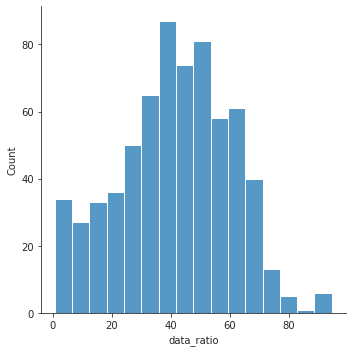

In [214]:
sns.displot(df_videos['data_ratio']);

In [215]:
df_videos['data_ratio'].describe().to_frame()

,data_ratio
count,671.00
mean,41.18
std,19.07
min,0.77
25%,28.45
50%,42.21
75%,54.86
max,94.55


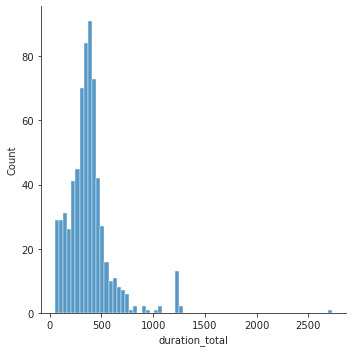

In [216]:
sns.displot(df_videos['duration_total']);

In [217]:
df_videos['duration_total'].describe().to_frame()

,duration_total
count,671.00
mean,377.96
std,223.71
min,50.00
25%,265.00
50%,365.00
75%,441.00
max,"2,725.00"


## df_words

In [262]:
def read_text(interval_id):
    raw_text_path = resolve_interval_raw_text_path(interval_id)
    return pd.read_csv(raw_text_path)

In [263]:
speaker_interval_ids = df_intervals['interval_id'].tolist()

In [264]:
speaker_interval_ids[100]

'cmu0000033842'

In [265]:
read_text('cmu0000033842')

,word,start_frame,end_frame,frames_count
0,to,0,12,12
1,see,12,38,26
2,what,38,42,4
3,is,42,53,11
4,Boxing,53,57,4
5,Day,57,59,2
6,brackets,59,71,12


In [266]:
interval_text_status = []
interval_id_to_df_words = {}
for interval_id in tqdm(speaker_interval_ids):
    try:
        df_words = read_text(interval_id)
        interval_id_to_df_words[interval_id] = df_words
        has_text = True
    except FileNotFoundError as e:
        has_text = False
    interval_text_status.append([interval_id, has_text])

  0%|          | 0/4367 [00:00<?, ?it/s]

In [267]:
len(interval_id_to_df_words)

4109

# Intervals Validity

## Interval PATS Text

### Has Groups (`valid_hd5`)

In [268]:
df_interval_text_status = pd.DataFrame(interval_text_status, columns=['interval_id', 'valid_hd5'])
df_intervals = df_intervals.merge(df_interval_text_status)
display_value_counts(df_intervals['valid_hd5'], 'Valid hd5 group')

,valid_hd5
True,4109
False,258


### Token Frames Duration (`valid_max_token_duration`)

In [269]:
MAX_SECONDS_PER_TOKEN = 4
MAX_FRAMES_THRESHOLD = FRAME_RATE * MAX_SECONDS_PER_TOKEN
print(f'Max allowed frames per token is: {MAX_FRAMES_THRESHOLD} frames (= {MAX_SECONDS_PER_TOKEN} seconds)')

Max allowed frames per token is: 60 frames (= 4 seconds)


In [270]:
UNKNOWN_MAX_FRAMES_PER_TOKEN = -1

def get_max_frames_number_for_token(interval_id):
    try:
        df_tokens = interval_id_to_df_words[interval_id]
        max_token_frames = df_tokens['frames_count'].max()
    except:
        max_token_frames = UNKNOWN_MAX_FRAMES_PER_TOKEN
    return max_token_frames

In [271]:
df_intervals['max_frames_token'] = df_intervals['interval_id'].progress_apply(get_max_frames_number_for_token)

  0%|          | 0/4367 [00:00<?, ?it/s]

In [272]:
df_intervals.head(n=2)

,Unnamed: 0,Unnamed: 0.1,dataset,duration,end_time,interval_id,speaker,start_time,video_fn,video_link,...,valid_duration,valid_single_token_per_frame,video_downloded,valid_hd5,valid_max_token_duration,valid_frames_count,duration_net,duration_total,data_ratio,valid_video_data_ratio
0,79922,79922,train,7.23,0 days 00:00:08.090000,cmu0000033570,noah,0 days 00:00:00.860000,rUZL4z5Drcw,https://www.youtube.com/watch?v=rUZL4z5Drcw,...,True,False,False,False,False,False,61.43,397,15.47,True
1,79923,79923,train,7.80,0 days 00:00:30.700000,cmu0000033572,noah,0 days 00:00:22.900000,rUZL4z5Drcw,https://www.youtube.com/watch?v=rUZL4z5Drcw,...,True,True,False,True,False,True,61.43,397,15.47,True


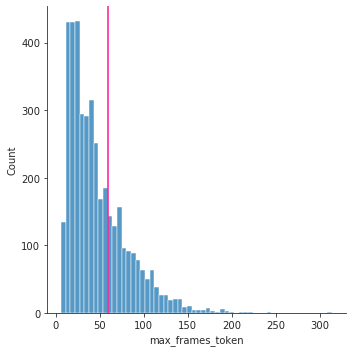

In [273]:
sns.set_style('ticks')
sns.displot(df_intervals[df_intervals['max_frames_token'] != -1]['max_frames_token'])
plt.axvline(MAX_FRAMES_THRESHOLD, color='deeppink');

In [274]:
mask_below_max_frames_limit = (df_intervals['max_frames_token'] < MAX_FRAMES_THRESHOLD)
mask_known_max_frames = (df_intervals['max_frames_token'] != UNKNOWN_MAX_FRAMES_PER_TOKEN) 

df_intervals['valid_max_token_duration'] = mask_below_max_frames_limit & mask_known_max_frames
display_value_counts(df_intervals['valid_max_token_duration'], 'Valid Token Duration')

,valid_max_token_duration
True,2936
False,1431


### Multiple Words Per Frame (`valid_single_token_per_frame`)

In [275]:
df_tokens = read_text('cmu0000035126')
# printmd(f'**Video path**: {resolve_interval_video_path("101204")}')
# printmd(f'**Text path**: {resolve_interval_text_path("101204")}')
print(f'Start token unique: {df_tokens["start_frame"].is_unique}')
df_tokens[24:40]

Start token unique: False


,word,start_frame,end_frame,frames_count
24,felt,149,154,5
25,that,154,155,1
26,you,155,157,2
27,need,157,160,3
28,to,160,161,1
29,do,161,163,2
30,you,163,181,18
31,need,181,181,0
32,to,181,184,3
33,get,184,185,1


In [276]:
MAX_TOKENS_PER_FRAME_LIMIT = 2 # allow not more two tokens with the same start frame

def valid_single_frame_tokens_count(interval_id):
    df_tokens = interval_id_to_df_words.get(interval_id)
    if df_tokens is None:
        return False
    max_tokens_per_frame = df_tokens['start_frame'].value_counts().max()
    return max_tokens_per_frame <= MAX_TOKENS_PER_FRAME_LIMIT

In [277]:
df_intervals['valid_single_token_per_frame'] = df_intervals['interval_id'].progress_apply(valid_single_frame_tokens_count)

  0%|          | 0/4367 [00:00<?, ?it/s]

In [278]:
display_value_counts(df_intervals['valid_single_token_per_frame'], f'Max of {MAX_TOKENS_PER_FRAME_LIMIT} tokens per frame')

,valid_single_token_per_frame
True,4059
False,308


### Frame Count (`valid_frames_count`)

In [279]:
def valid_interval_frame_count(interval_id, duration):
    df_tokens = interval_id_to_df_words.get(interval_id)
    if df_tokens is None:
        return False
    total_frames = df_tokens['end_frame'].max()
    max_tokens_per_frame = df_tokens['start_frame'].value_counts().max()
    lower_bound = (duration - 2) * FRAME_RATE
    upper_bound = (duration + 1) * FRAME_RATE
    is_valid = lower_bound <= total_frames <= upper_bound
    debug_symbol = '✓' if is_valid else '✗'
    if interval_id in df_intervals['interval_id'][:10].tolist():
        print(debug_symbol, interval_id, round(lower_bound, 2), total_frames, round(upper_bound, 2))
    return lower_bound <= total_frames <= upper_bound

In [280]:
df_intervals['valid_frames_count'] = df_intervals[['interval_id', 'duration']].progress_apply(lambda x: valid_interval_frame_count(*x), axis=1)

  0%|          | 0/4367 [00:00<?, ?it/s]

✓ cmu0000033572 87.0 118 132.0
✓ cmu0000033573 210.5 241 255.5
✓ cmu0000033576 230.5 261 275.5
✓ cmu0000033589 165.0 196 210.0
✓ cmu0000033591 537.0 568 582.0
✓ cmu0000033592 149.5 180 194.5
✓ cmu0000033594 238.0 269 283.0
✓ cmu0000033595 525.0 556 570.0
✓ cmu0000033596 57.5 88 102.5


In [281]:
display_value_counts(df_intervals['valid_frames_count'], f'Frame Count = Frame Rate * Seconds')

,valid_frames_count
True,4109
False,258


In [282]:
read_text('cmu0000035126').head(n=20)

,word,start_frame,end_frame,frames_count
0,granny,0,40,40
1,you,40,58,18
2,think,58,62,4
3,he's,62,65,3
4,doing,65,67,2
5,a,67,70,3
6,good,70,73,3
7,job,73,76,3
8,as,76,82,6
9,president,82,85,3


## Interval Video

### Total Duration (`valid_duration`)

In [283]:
MIN_DURATION_SECS_THRESHOLD = 5

In [284]:
df_intervals.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'dataset', 'duration', 'end_time',
       'interval_id', 'speaker', 'start_time', 'video_fn', 'video_link',
       'org_start_time', 'org_end_time', 'start_time_string',
       'end_time_string', 'video_id', 'max_frames_token', 'valid',
       'valid_duration', 'valid_single_token_per_frame', 'video_downloded',
       'valid_hd5', 'valid_max_token_duration', 'valid_frames_count',
       'duration_net', 'duration_total', 'data_ratio',
       'valid_video_data_ratio'],
      dtype='object')

In [285]:
df_intervals['valid_duration'] = MIN_DURATION_SECS_THRESHOLD < df_intervals['duration']

In [286]:
df_intervals.dtypes

Unnamed: 0                        int64
Unnamed: 0.1                      int64
dataset                          object
duration                        float64
end_time                         object
interval_id                      object
speaker                          object
start_time                       object
video_fn                         object
video_link                       object
org_start_time                   object
org_end_time                     object
start_time_string                object
end_time_string                  object
video_id                         object
max_frames_token                  int64
valid                              bool
valid_duration                     bool
valid_single_token_per_frame       bool
video_downloded                    bool
valid_hd5                          bool
valid_max_token_duration           bool
valid_frames_count                 bool
duration_net                    float64
duration_total                    int64


In [287]:
display_value_counts(df_intervals['valid_duration'], f'Duration > {MIN_DURATION_SECS_THRESHOLD} seconds')

,valid_duration
True,4150
False,217


## Intervals.merge(Videos)

In [323]:
# df_intervals.drop('Unnamed: 0', inplace=True, axis=1)
# df_intervals.drop('Unnamed: 0.1', inplace=True, axis=1)
# df_intervals.drop('duration_total_x', inplace=True, axis=1)

In [324]:
df_intervals.columns

Index(['dataset', 'duration', 'end_time', 'interval_id', 'speaker',
       'start_time', 'video_fn', 'video_link', 'org_start_time',
       'org_end_time', 'start_time_string', 'end_time_string', 'video_id',
       'max_frames_token', 'valid', 'valid_duration',
       'valid_single_token_per_frame', 'video_downloded', 'valid_hd5',
       'valid_max_token_duration', 'valid_frames_count'],
      dtype='object')

In [325]:
df_videos.columns

Index(['speaker', 'duration_net', 'video_id', 'video_link', 'duration_total',
       'data_ratio'],
      dtype='object')

In [326]:
set(df_intervals.columns) & set(df_videos.columns)

{'speaker', 'video_id', 'video_link'}

In [327]:
df_intervals = df_intervals.merge(df_videos, on=['speaker', 'video_id', 'video_link'])

In [329]:
df_intervals.columns

Index(['dataset', 'duration', 'end_time', 'interval_id', 'speaker',
       'start_time', 'video_fn', 'video_link', 'org_start_time',
       'org_end_time', 'start_time_string', 'end_time_string', 'video_id',
       'max_frames_token', 'valid', 'valid_duration',
       'valid_single_token_per_frame', 'video_downloded', 'valid_hd5',
       'valid_max_token_duration', 'valid_frames_count', 'duration_net',
       'duration_total', 'data_ratio'],
      dtype='object')

### Total Duration (`valid_video_data_ratio`)

In [330]:
# The minimal allowed ratio between the total length of the intervals, to the full video length
MIN_VIDEO_DATA_RATIO_THRESHOLD = 10

In [331]:
df_intervals['valid_video_data_ratio'] = df_intervals['data_ratio'] > MIN_VIDEO_DATA_RATIO_THRESHOLD

In [332]:
display_value_counts(df_intervals['valid_video_data_ratio'], f'Video data ratio > {MIN_VIDEO_DATA_RATIO_THRESHOLD}%')

,valid_video_data_ratio
True,4278
False,89


## Finalize Valid

In [333]:
df_intervals.columns[df_intervals.columns.str.contains('valid_')].tolist()

['valid_duration',
 'valid_single_token_per_frame',
 'valid_hd5',
 'valid_max_token_duration',
 'valid_frames_count',
 'valid_video_data_ratio']

In [334]:
df_intervals.drop('valid_max_frames_per_token', axis=1, errors='ignore', inplace=True)

In [336]:
COLS_VALID = [
    'valid_duration',
    'valid_single_token_per_frame',
    'valid_hd5',
    'valid_max_token_duration',
    'valid_frames_count',
    'valid_video_data_ratio'
]

In [337]:
total_intervals = len(df_intervals)
df_validity_summary = df_intervals[COLS_VALID].sum().to_frame().rename(columns={0: 'records'})
df_validity_summary['%records'] = df_validity_summary['records'] / total_intervals * 100
df_validity_summary

,records,%records
valid_duration,4150,95.03
valid_single_token_per_frame,4059,92.95
valid_hd5,4109,94.09
valid_max_token_duration,2936,67.23
valid_frames_count,4109,94.09
valid_video_data_ratio,4278,97.96


In [338]:
df_intervals['valid'] = df_intervals[COLS_VALID].all(axis=1)
display_value_counts(df_intervals['valid'], 'Valid Intervals')

,valid
True,2657
False,1710


In [339]:
df_validity_summary = df_intervals[['valid'] + COLS_VALID].sum().to_frame().rename(columns={0: 'records'})
df_validity_summary['%records'] = df_validity_summary['records'] / total_intervals * 100
df_validity_summary

,records,%records
valid,2657,60.84
valid_duration,4150,95.03
valid_single_token_per_frame,4059,92.95
valid_hd5,4109,94.09
valid_max_token_duration,2936,67.23
valid_frames_count,4109,94.09
valid_video_data_ratio,4278,97.96


In [340]:
df_intervals[['valid'] + COLS_VIEW + COLS_VALID].head(n=2)

,valid,speaker,interval_id,duration,start_time_string,end_time_string,video_link,valid_duration,valid_single_token_per_frame,valid_hd5,valid_max_token_duration,valid_frames_count,valid_video_data_ratio
0,False,noah,cmu0000033570,7.23,00:00:00.86,00:00:08.9,https://www.youtube.com/watch?v=rUZL4z5Drcw,True,False,False,False,False,True
1,False,noah,cmu0000033572,7.80,00:00:22.90,00:00:30.70,https://www.youtube.com/watch?v=rUZL4z5Drcw,True,True,True,False,True,True


# Download Data

## df_intervals.to_csv

In [341]:
df_intervals.columns

Index(['dataset', 'duration', 'end_time', 'interval_id', 'speaker',
       'start_time', 'video_fn', 'video_link', 'org_start_time',
       'org_end_time', 'start_time_string', 'end_time_string', 'video_id',
       'max_frames_token', 'valid', 'valid_duration',
       'valid_single_token_per_frame', 'video_downloded', 'valid_hd5',
       'valid_max_token_duration', 'valid_frames_count', 'duration_net',
       'duration_total', 'data_ratio', 'valid_video_data_ratio'],
      dtype='object')

In [97]:
df_intervals.rename(
    columns={'duration_net':   'video_duration_net',
             'duration_total': 'video_duration_total',
             'data_ratio':     'video_data_ratio'},
    axis=1, inplace=True)

In [350]:
COLS_OUTPUT = [
    # core
    'speaker', 'video_id', 'interval_id', 'valid',
    # features
    'duration', 'start_time_string',  'end_time_string',
    'video_link', 'video_fn',
    'start_time', 'end_time',
    'org_start_time', 'org_end_time',
    # video info
#     'video_duration_net', 'video_duration_total', 'video_data_ratio',
    # validity
    'max_frames_token',
    'valid_duration', 'valid_single_token_per_frame', 'valid_hd5',
    'valid_max_token_duration', 'valid_frames_count', 'valid_video_data_ratio'
]

In [351]:
len(df_intervals.columns), len(COLS_OUTPUT)

(21, 20)

In [354]:
df_intervals_prev = df_intervals.copy()
df_intervals = df_intervals[COLS_OUTPUT]
df_intervals.head(n=2)

,speaker,video_id,interval_id,valid,duration,start_time_string,end_time_string,video_link,video_fn,start_time,end_time,org_start_time,org_end_time,max_frames_token,valid_duration,valid_single_token_per_frame,valid_hd5,valid_max_token_duration,valid_frames_count,valid_video_data_ratio
0,noah,rUZL4z5Drcw,cmu0000033570,False,7.23,00:00:00.86,00:00:08.9,https://www.youtube.com/watch?v=rUZL4z5Drcw,rUZL4z5Drcw,0 days 00:00:00.860000,0 days 00:00:08.090000,0 days 00:00:00.860000,0 days 00:00:08.090000,-1,True,False,False,False,False,True
1,noah,rUZL4z5Drcw,cmu0000033572,False,7.80,00:00:22.90,00:00:30.70,https://www.youtube.com/watch?v=rUZL4z5Drcw,rUZL4z5Drcw,0 days 00:00:22.900000,0 days 00:00:30.700000,0 days 00:00:22.900000,0 days 00:00:30.700000,118,True,True,True,False,True,True


In [355]:
intervals_output_path = os.path.join('/home/stav/Data/PATS_DATA', f'df_intervals_{SPEAKER_NAME}.csv')
printmd(f'{TAB} → df_intervals {intervals_output_path}')
df_intervals.to_csv(intervals_output_path, index=False, header=True)

&nbsp;&nbsp;&nbsp;&nbsp; → df_intervals /home/stav/Data/PATS_DATA/df_intervals_noah.csv

In [356]:
print(df_intervals[df_intervals['valid']]['interval_id'].tolist())

['cmu0000033573', 'cmu0000033576', 'cmu0000033589', 'cmu0000033592', 'cmu0000033594', 'cmu0000033596', 'cmu0000033599', 'cmu0000033600', 'cmu0000033602', 'cmu0000033605', 'cmu0000033608', 'cmu0000033610', 'cmu0000033617', 'cmu0000033622', 'cmu0000033628', 'cmu0000033656', 'cmu0000033658', 'cmu0000033661', 'cmu0000033663', 'cmu0000033664', 'cmu0000033666', 'cmu0000033671', 'cmu0000033673', 'cmu0000033674', 'cmu0000033675', 'cmu0000033676', 'cmu0000033682', 'cmu0000033697', 'cmu0000033699', 'cmu0000033700', 'cmu0000033702', 'cmu0000033703', 'cmu0000033704', 'cmu0000033706', 'cmu0000033710', 'cmu0000033711', 'cmu0000033714', 'cmu0000033722', 'cmu0000033723', 'cmu0000033725', 'cmu0000033726', 'cmu0000033730', 'cmu0000033745', 'cmu0000033747', 'cmu0000033750', 'cmu0000033765', 'cmu0000033770', 'cmu0000033772', 'cmu0000033780', 'cmu0000033781', 'cmu0000033783', 'cmu0000033784', 'cmu0000033793', 'cmu0000033799', 'cmu0000033801', 'cmu0000033802', 'cmu0000033811', 'cmu0000033817', 'cmu000003382

In [357]:
printmd(f'[VALID] Speaker **{SPEAKER_NAME}**:')
print_df_info(df_intervals[df_intervals['valid']])

[VALID] Speaker **noah**:

  ◘ Videos: #598
  ◘ Intervals: #2,657
  ◘ Total Duration: 14 hours, 36 minutues, 04 seconds (52,564 seconds)
  ◘ All are Youtube videos: True


In [358]:
printmd(f'[ALL] Speaker **{SPEAKER_NAME}**:')
print_df_info(df_intervals)

[ALL] Speaker **noah**:

  ◘ Videos: #671
  ◘ Intervals: #4,367
  ◘ Total Duration: 04 hours, 03 minutues, 30 seconds (101,010 seconds)
  ◘ All are Youtube videos: True
